# Metadata analysis and script generation for Lori Allen Data Processing

In [1]:
import numpy as np
import pickle
from astropy.io.votable import parse
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp
import pointing_groups as pg

%matplotlib inline

# Data and data masking

In [2]:
"""
df = pg.load_raw_data()
Pointing_Groups = pg.sort_pointings(df)
pg.pickle_pointings(Pointing_Groups)
"""

with open('PickledPointings.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
    
den_visit,den_ccd,den_stellarnum = np.loadtxt('ref_data.txt',unpack=True)
unique_den_visit = np.unique(den_visit)
max_stellarnum = []
_= [ max_stellarnum.append(np.max(den_stellarnum[den_visit==visit])) for visit in unique_den_visit ]
max_stellarnum = np.array(max_stellarnum)

for i,group in enumerate(Pointing_Groups):
    group_max = np.concatenate([ (max_stellarnum[(unique_den_visit==x)]) for x in np.array(Pointing_Groups[i]["visit_id"],dtype=np.float_) ])
    if not(group_max.size):
        group_max=[-9999.]
    group_max = np.max(group_max)
    Pointing_Groups[i]['stellar_density'] = group_max
    
# visitToIndex is a dictionary that returns the index of a given visit
visitToIndex = {}
for i,pointing in enumerate(Pointing_Groups):
    for visit in pointing['visit_id']:
        visitToIndex[str(visit)] = i

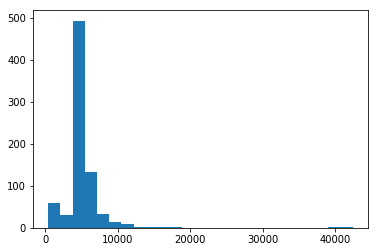

In [3]:
den_visits,den_ccd,den_count = np.loadtxt('ref_data.txt',unpack=True)
unique_visits = np.unique(den_visits)
max_den = -9999*np.ones(len(unique_visits))

for i,visit in enumerate(unique_visits):
    max_den[i]=np.max(den_count[den_visits==visit])
    
_=plt.hist(max_den,bins=25)

for i in range(len(Pointing_Groups)):
    Pointing_Groups[i]['stellar_den'] = max_den[unique_visits==Pointing_Groups[i]['visit_id'][0]][0]
    
for pointing in Pointing_Groups:
    if pointing['stellar_den'][0] != np.mean(pointing['stellar_den']):
        print('Bad stellar density at {visit}'.format(visit=pointing['visit_id'][0]))

In [4]:
# We define "Bad Groups" as groups where the maximum separation between image centers is greater than 25 arcsec

Bad_Group_Index = []
Arcsec_Tol = 25 # Tolerance defining a bad group in arcseconds
for i in range(len(Pointing_Groups)):
    RAResidual = Pointing_Groups[i]["ra"].values-np.mean(Pointing_Groups[i]["ra"].values)
    RAResidual*=3600
    DECResidual = Pointing_Groups[i]["dec"].values-np.mean(Pointing_Groups[i]["dec"].values)
    if (np.max(abs(RAResidual))>Arcsec_Tol or np.max(abs(DECResidual))>Arcsec_Tol):
        Bad_Group_Index.append(i)
    DECResidual*=3600
    #plt.plot(RAResidual,'r')
    #plt.plot(DECResidual,'b')
    
print("There are {bad_group_num} bad groups in the data.".format(bad_group_num=len(Bad_Group_Index)))
print("The indicies for the bad groups are:\n"+str(Bad_Group_Index))

There are 28 bad groups in the data.
The indicies for the bad groups are:
[28, 169, 170, 184, 408, 424, 425, 426, 427, 428, 429, 430, 506, 509, 533, 534, 537, 538, 540, 541, 542, 633, 683, 717, 718, 719, 722, 724]


/home/hayden/.anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


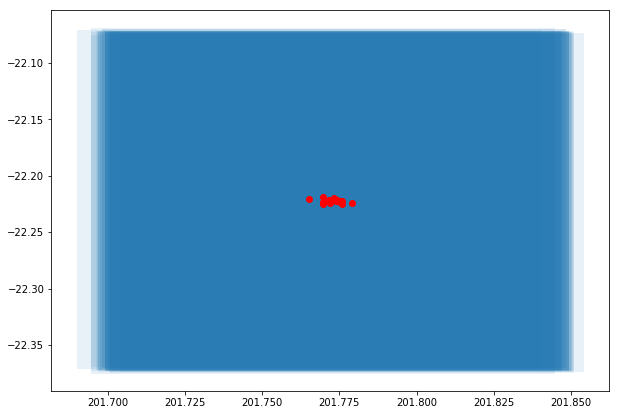

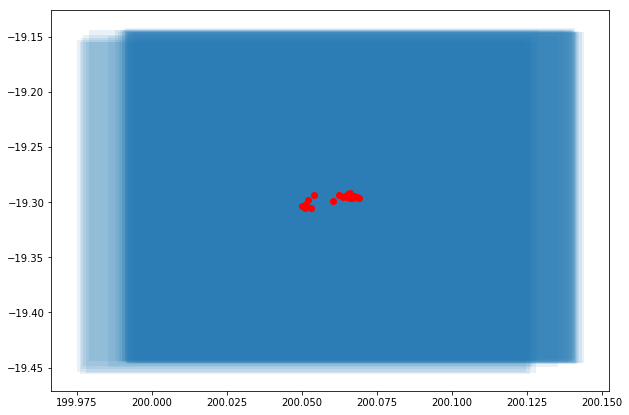

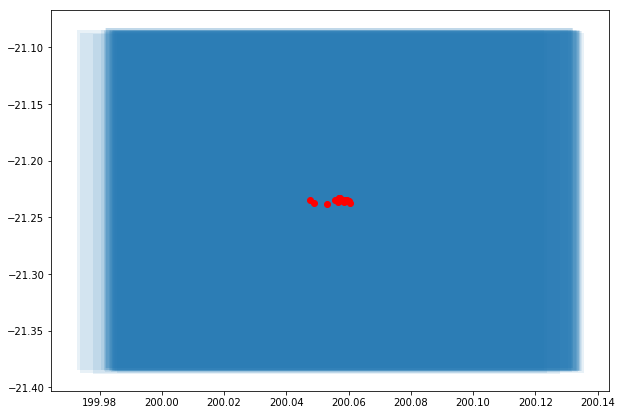

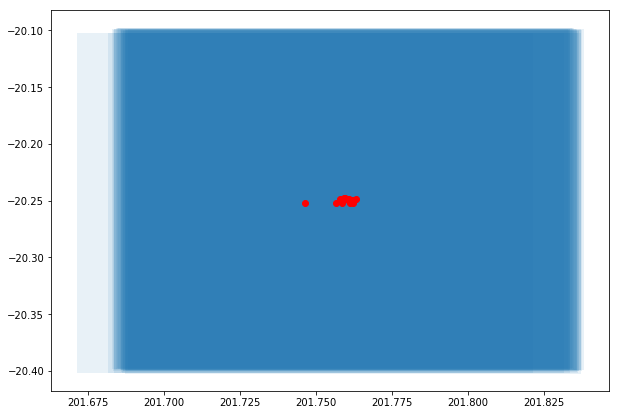

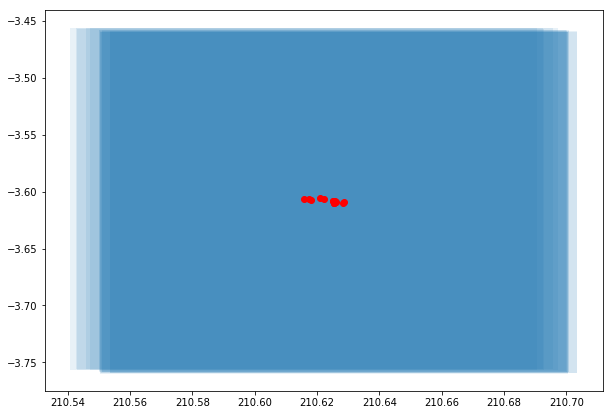

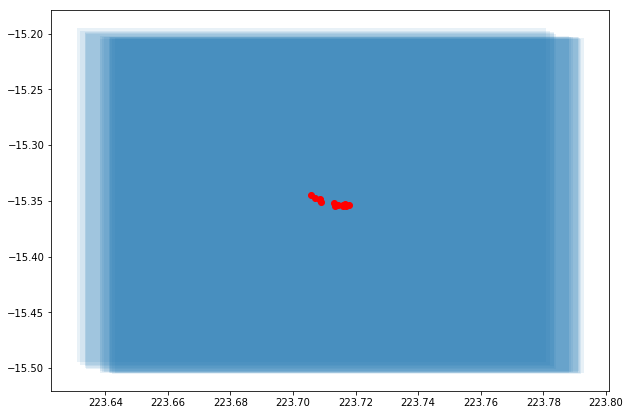

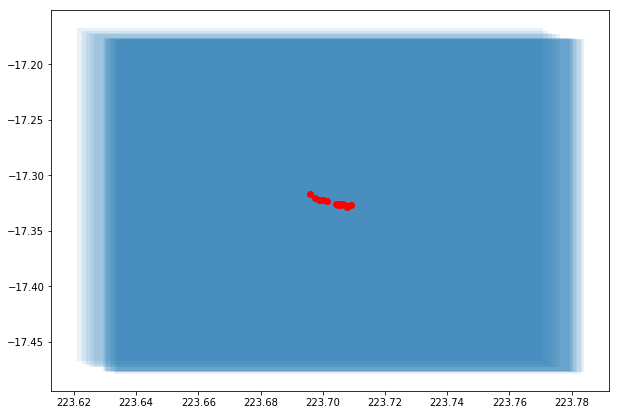

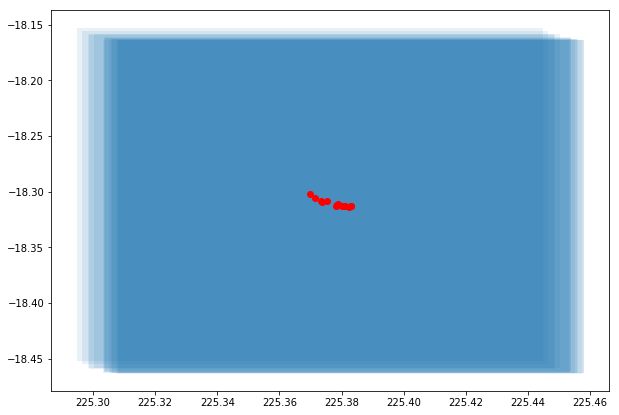

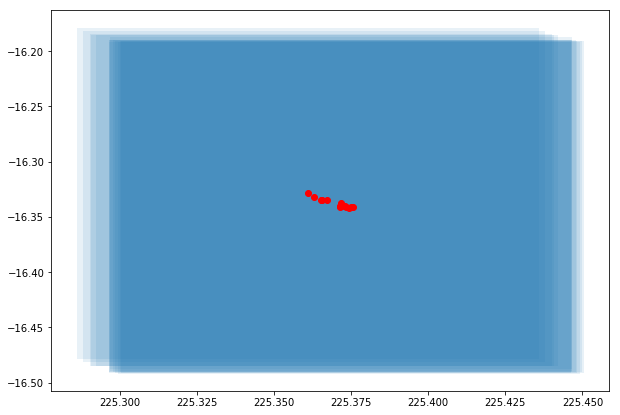

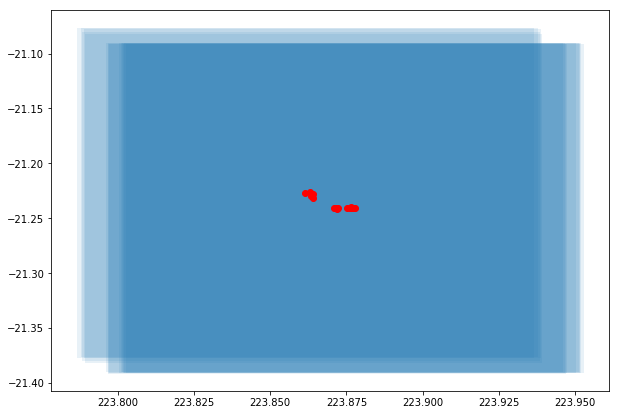

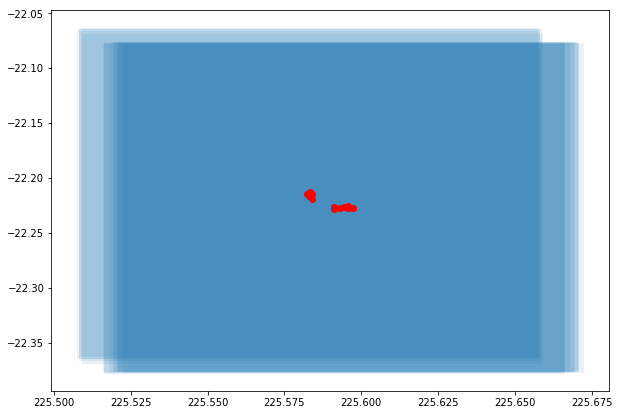

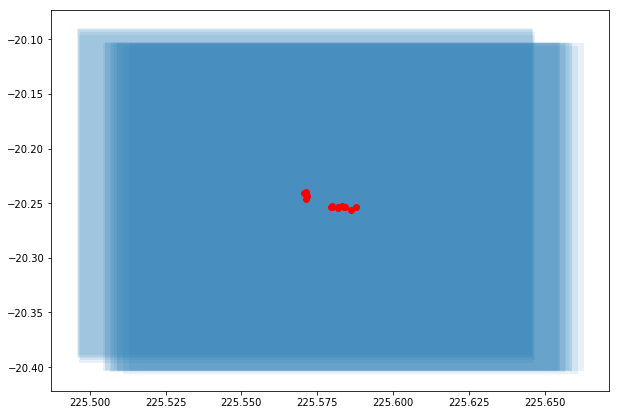

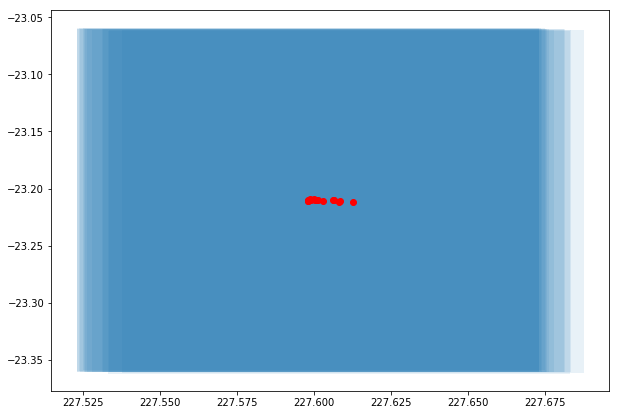

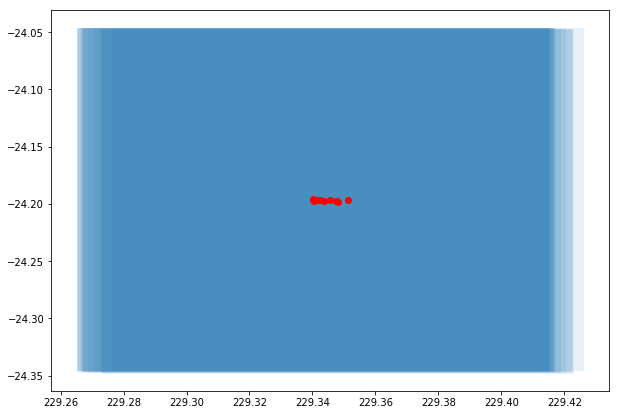

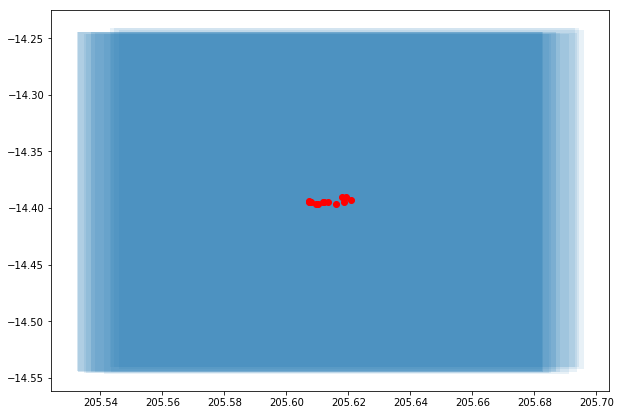

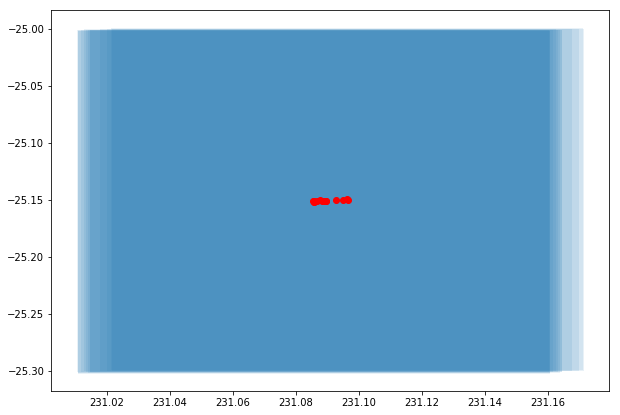

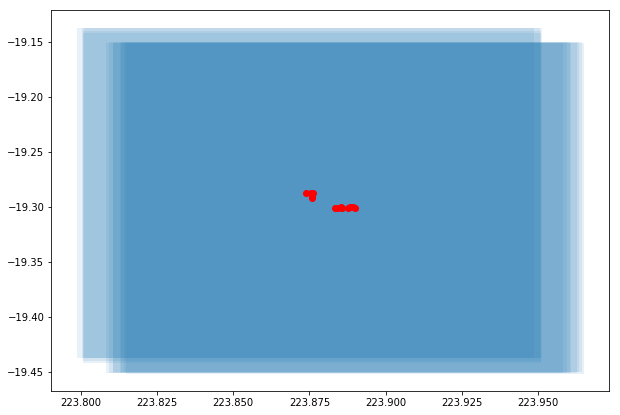

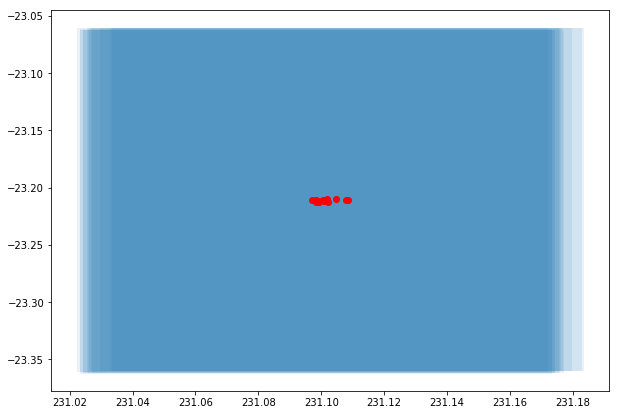

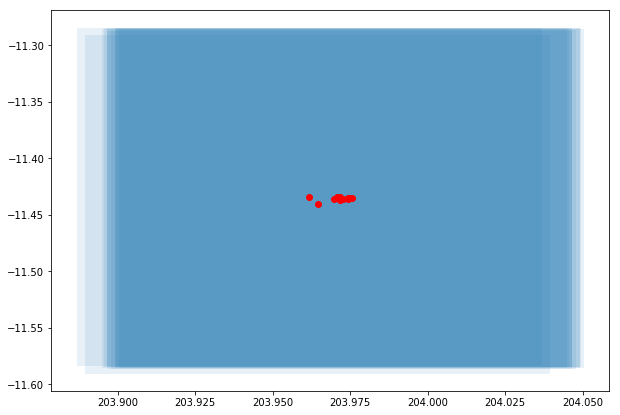

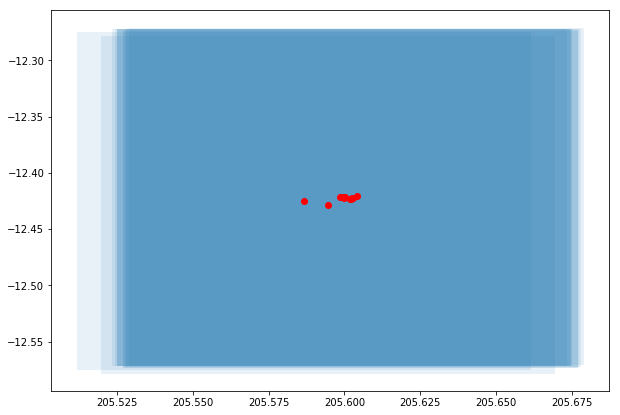

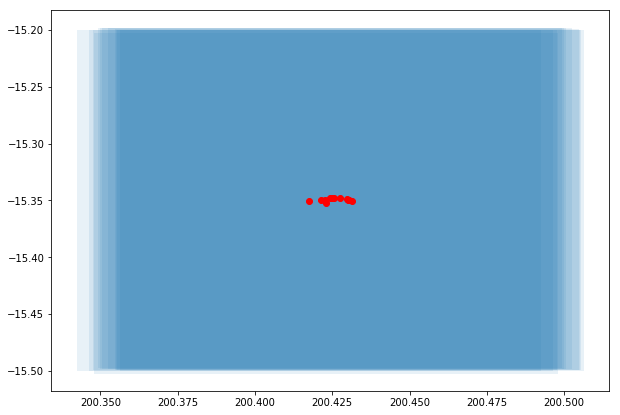

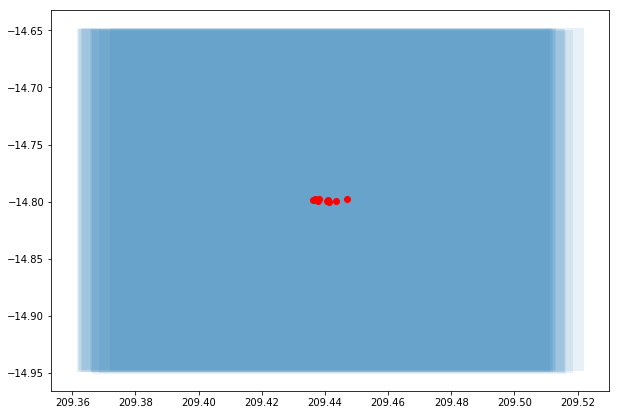

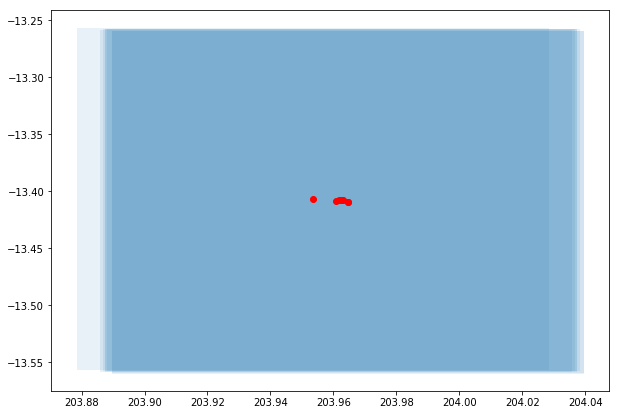

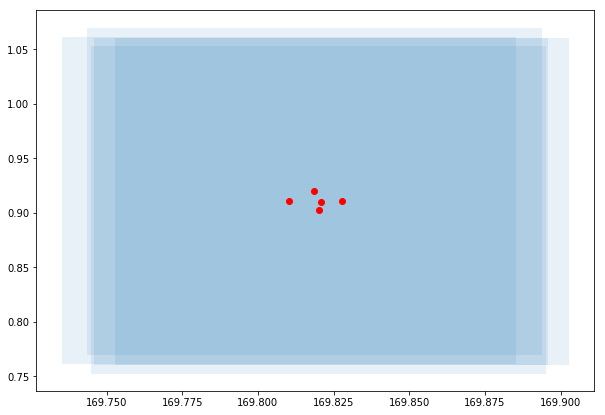

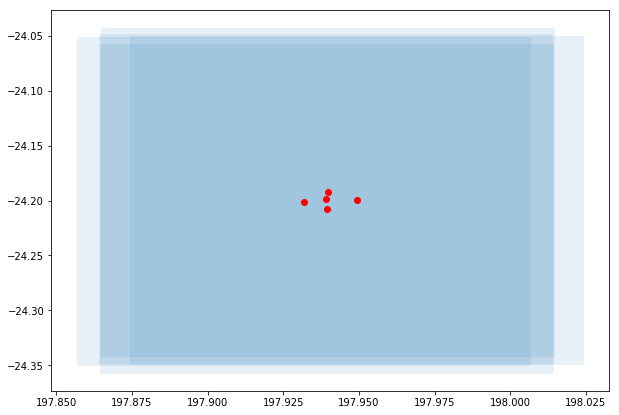

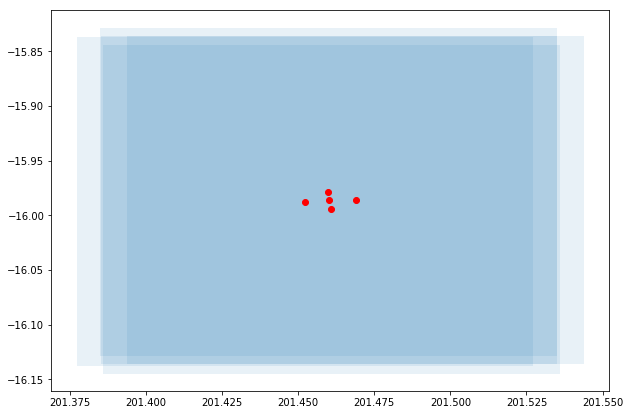

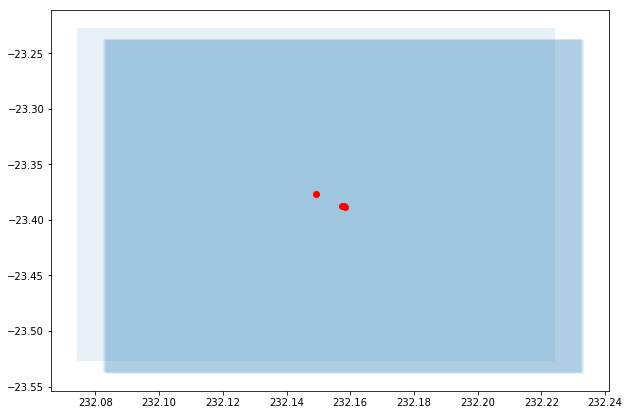

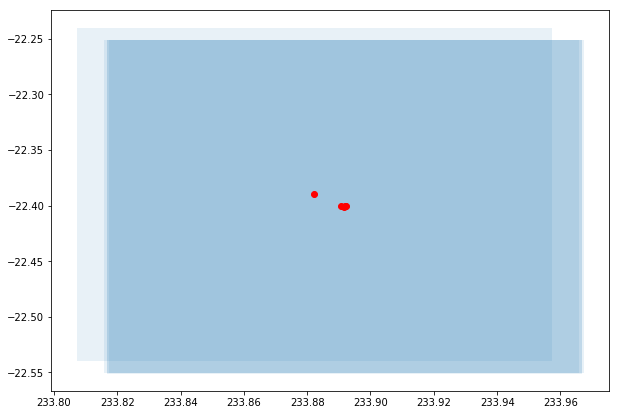

In [5]:
# This cell plots the bad pointings in order to visualize the spread of pointings in the bad pointing groups
#%matplotlib notebook
for index in Bad_Group_Index:
    pg.plot_pointings(Pointing_Groups[index]["visit_id"],Pointing_Groups[index]["ra"],Pointing_Groups[index]["dec"])

# Script generation

In [8]:
import jobmaker
import matcher

## ProcessCCD.py

In [10]:
# This cell creates the linking script for processing the dataset on hyak
jobmaker.link_instcal_files(Pointing_Groups,'/gscratch/scrubbed/smotherh/NEO',
                       '/gscratch/scrubbed/smotherh/refcats/htm',
                       '/gscratch/scrubbed/smotherh/pointing_groups',script_name='link_files_hyak.sh')

In [9]:
jobmaker.process_visits(Pointing_Groups,'/gscratch/scrubbed/smotherh/pointing_groups',
                        [770,781],script_name='process_visits770_hyak.sh',num_cores=28)

In [8]:
# This cell generates the bash linking script for getting one image from each field.
# c4d_140429_024704_ooi_VR_v1.fits.fz has INDEF for MAGZERO and causes a bug

with open("link_files_SampleFields.sh", "w") as f:

    dir_name = "SampleFields"
    f.write('\n# Link files for field: '+dir_name+'\n')
    f.write('mkdir '+dir_name+'\n')
    f.write('mkdir '+dir_name+'/ingest/\n')
    f.write('mkdir '+dir_name+'/ingest/instcal\n')
    f.write('mkdir '+dir_name+'/ingest/dqmask\n')
    f.write('mkdir '+dir_name+'/ingest/wtmap\n')
    for i in range(len(Pointing_Groups)):
        if Pointing_Groups[i]["survey_night"][0] != 3:
            link_files = ("ln -s /astro/store/pogo4/jbkalmbach/NEO/night_{nightnum}/night_{nightnum}/{filename} {destination}\n")
        else:
            link_files = ("ln -s /astro/store/pogo4/jbkalmbach/NEO/night_{nightnum}/night_{nightnum}/night_{nightnum}/{filename} {destination}\n")


        dqmask = Pointing_Groups[i]['filename'][0].decode('UTF-8')[0:20]+'d'+Pointing_Groups[i]['filename'][0].decode('UTF-8')[21:]
        wtmap = Pointing_Groups[i]['filename'][0].decode('UTF-8')[0:20]+'w'+Pointing_Groups[i]['filename'][0].decode('UTF-8')[21:]
        
        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/instcal/\n'
        f.write(link_files.format(nightnum=Pointing_Groups[i]["survey_night"][0],filename=Pointing_Groups[i]["filename"][0].decode('UTF-8'),destination=destination))

        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/dqmask/\n'
        f.write(link_files.format(nightnum=Pointing_Groups[i]["survey_night"][0],filename=dqmask,destination=destination))
        
        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/wtmap/\n'
        f.write(link_files.format(nightnum=Pointing_Groups[i]["survey_night"][0],filename=wtmap,destination=destination))

## Image Differencing

In [12]:
default_epyc_settings = {
    "in_repos_topdir"  : "/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/",
    "out_repos_topdir" : "/epyc/users/dinob/imdiff/DECAM_DiffIm/pointing_group_imdiffs/",
    "cfgfile_path"     : "/epyc/users/dinob/imdiff/DECAM_DiffIm/config.py",

    "in_repo_rerun_dirstr" : "Pointing_Group_{groupid:03d}/processed_data/rerun/rerun_processed_data/",
    "out_saveloc_dirstr"   : "{groupid:03d}",
    
    "stdoutstr" : "imdiff_{visitid}.out",
    "stderrstr" : "imdiff_{visitid}.err",

    "script_namestr" : "job_group_{groupid:03d}",
    "self.save_path" : ".",

    "parallel" : True,
    "longlog"  : True,
    "limited"  : True,
    "perccd"   : False,
    "niced"    : True,

    "timeout" : 86400,
    "niceness" : "17",
    "ncpu" : 20,
    "ccd" : 1,
}

In [13]:
default_hyak_settings = {
    "in_repos_topdir"  : "/gscratch/scrubbed/smotherh/pointing_groups/",
    "out_repos_topdir" : "/gscratch/scrubbed/dinob/imdiff",
    "cfgfile_path"     : "/gscratch/scrubbed/dinob/config.py",

    "in_repo_rerun_dirstr" : "Pointing_Group_{groupid:03d}/processed_data/rerun/rerun_processed_data/",
    "out_saveloc_dirstr"   : "{groupid:03d}",
    
    "stdoutstr" : "imdiff_{visitid}.out",
    "stderrstr" : "imdiff_{visitid}.err",

    "script_namestr" : "slurm_group_{groupid:03d}",
    "self.save_path" : ".",

    "parallel" : False,
    "longlog"  : True,
    "limited"  : False,
    "perccd"   : False,
    "niced"    : False,

    "timeout" : 86400,
    "niceness" : "17",
    "ncpu" : 20,
    "ccd" : 10,
}

In [ ]:
conf = jobmaker.JobConf(**default_hyak_settings)
conf.save_path = "/home/dino/Desktop/slurmjobs/"
for groupid in range(300, 731):
    jobmaker.slurm_script_from_groupid(Pointing_Groups, groupid, conf)

## Image Warping

In [15]:
default_warp_settings = default_hyak_settings.copy()

default_warp_settings["in_repos_topdir"]  = "/gscratch/scrubbed/dinob/imdiff"
default_warp_settings["out_repos_topdir"] = "/gscratch/scrubbed/dinob/warps"

default_warp_settings["stdoutstr"] = "warp_{visitid:03d}.out"
default_warp_settings["stderrstr"] = "warp_{visitid:03d}.err"
default_warp_settings["script_namestr"] = "warp_group_{groupid:03d}"

warpcmd = "./warp.py {groupid} > {stdoutpath} 2>{stderrpath}"

In [16]:
conf = jobmaker.JobConf(**default_warp_settings)
jobmaker.slurm_warp_script_from_groupid(40, conf, cmd=warpcmd)

## KBMOD

In [ ]:
with open("run_warps.sh")

f.write("./warp.py 301 > /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/301/warp301.out 2>/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/301/warp301.err")

# Analysis and plotting

In [9]:
import astropy.units as u

def findMinVel(max_time,max_distance=200*u.AU):
    
    if max_time.si >= .5*u.yr:
        Reflex_Distance = 2*u.AU
    else:
        theta = np.pi*u.radian*max_time/(1*u.yr)
        theta =theta.to(u.radian)
        if theta > np.pi/2 * u.radian:
            theta -= np.pi/2 * u.radian
            
        print(theta)
        Reflex_Distance = 2*np.sin(theta)*1*u.AU
    
    parallax_angle = np.arctan(Reflex_Distance/(2*max_distance))
    angular_speed = parallax_angle/max_time
    angular_speed = angular_speed.to(u.arcsec/u.hr)
    return(angular_speed)

In [10]:
findMinVel(1*u.day,max_distance=100*u.AU)


0.008601211919479242 rad


<Quantity 0.7392106 arcsec / h>

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


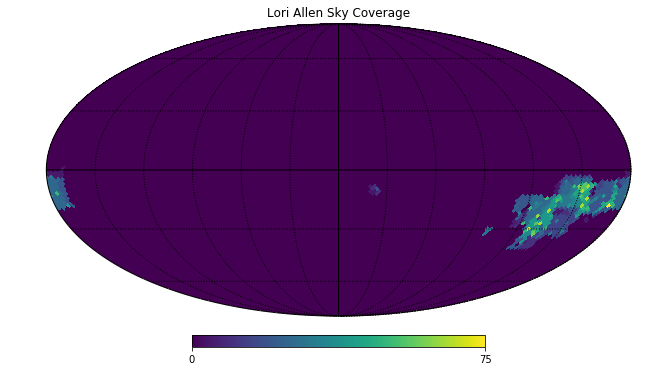

In [11]:
RA = []
DEC = []

for i,pointing in enumerate(Pointing_Groups):
    RA.append(pointing["ra"])
    DEC.append(pointing["dec"])
    
RA = np.concatenate(RA)
DEC = np.concatenate(DEC)

NSIDE =  32 #nside determines the size of the pixels
pixels = hp.ang2pix(NSIDE, np.radians(90-DEC), np.radians(RA)) #NOTE healpy uses colatitude (north pole 0) instead of latitude
hitmap = np.ones(hp.nside2npix(NSIDE)) * hp.UNSEEN #by convention non   hit pixels have a specific value
pixels_binned = np.bincount(pixels)
hitmap[:len(pixels_binned)] =  pixels_binned
hitmap[hitmap==hp.UNSEEN] = 0
hp.mollview(hitmap, xsize=2000,title='Lori Allen Sky Coverage')
hp.graticule() 
plt.savefig('Lori_Allen_Sky_Coverage.pdf')

12894
12894


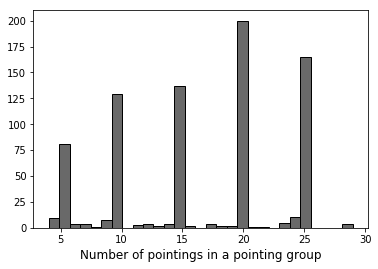

In [12]:
visit_id=np.concatenate([np.array(field["visit_id"],dtype=np.float_) for field in Pointing_Groups])
print(len(visit_id))
print(len(np.unique(visit_id)))
plt.figure()
num_visits = [len(pointing) for pointing in Pointing_Groups]
_=plt.hist(num_visits,bins=29,color='dimgrey',edgecolor='k')
plt.xlabel('Number of pointings in a pointing group',fontsize=12)
plt.savefig('pointings_hist.pdf')

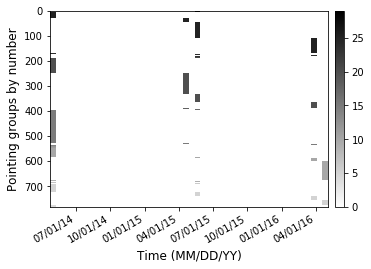

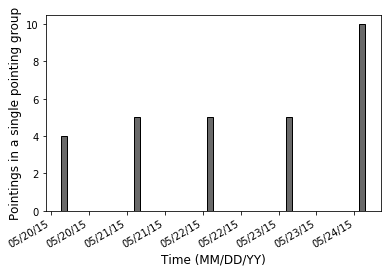

In [13]:
import matplotlib.dates as mdates
import datetime as dt
from dateutil.parser import parse

times=[[]]*len(Pointing_Groups)
for i,pointing in enumerate(Pointing_Groups):
    times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
    for j in range(len(Pointing_Groups[i]['date_obs'])):
        foo = parse(Pointing_Groups[i]['date_obs'][j])
        times[i][j]= foo.timestamp()

times=np.array(times)

hist_times = [[]]*len(times)
min_time=np.min(np.concatenate(times))
max_time=np.max(np.concatenate(times))

for i,time in enumerate(times):
    hist_times[i],bin_edges = np.histogram(time,range=[min_time,max_time],bins=50)
hist_times = np.array(hist_times)

x0=dt.datetime.fromtimestamp(bin_edges[0])
x1=dt.datetime.fromtimestamp(bin_edges[-1])
x_lims = mdates.date2num([x0,x1])

fig,ax1 = plt.subplots()

#cut_hist_times = [[]]*len(times)
#hist_times[hist_times==0]=-9999
im=ax1.imshow(hist_times,aspect='auto',extent=(x_lims[0],x_lims[1],len(hist_times),0),cmap='binary')
fig.colorbar(im,ax=ax1,pad=0.02)


ax1.xaxis_date()

date_format = mdates.DateFormatter('%D')

ax1.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

ax1.set_xlabel('Time (MM/DD/YY)',fontsize=12)
ax1.set_ylabel('Pointing groups by number',fontsize=12)
plt.savefig('total_time_data.pdf')

fig,ax2 = plt.subplots()

pg2_times = np.array([mdates.date2num(parse(x)) for x in Pointing_Groups[0]['date_obs']])

ax2.hist(pg2_times,bins=50,color='dimgrey',edgecolor='k')

ax2.xaxis_date()
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.set_xlabel('Time (MM/DD/YY)',fontsize=12)
ax2.set_ylabel('Pointings in a single pointing group',fontsize=12)
fig.autofmt_xdate()
plt.savefig('example_time_data.pdf')
plt.show()


(782, 50)


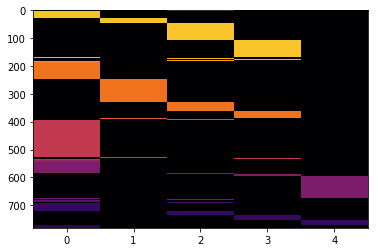

In [14]:
a = hist_times
print(np.shape(a))
bar = np.array([b[~(a==0).all(0)] for b in a])
plt.imshow(bar,aspect='auto',cmap='inferno')

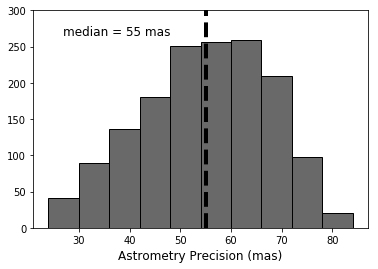

In [16]:
# We can parse the astrometry measurements from the log using the command:
# grep -i "arcsec" processCcd.log | cut -f2- -d= > astrometry.log

astrometry,astrom_err=np.loadtxt('astrometry.log',unpack=True,usecols=(0,2))
fig,ax = plt.subplots()
ax.hist(astrometry*1000,edgecolor='k',color='dimgrey')
plt.text(0.25, 0.9,'median = {0:.0f} mas'.format(np.median(astrometry)*1000),
         ha='center', va='center', transform=ax.transAxes,fontsize=12)
plt.xlabel('Astrometry Precision (mas)',fontsize=12)
plt.vlines(np.median(astrometry)*1000,0,400,lw=4,linestyles='--',color='k')
plt.ylim([0,300])
plt.savefig('astrometry_example.pdf')

In [101]:
i=0
for pointing in Pointing_Groups:
    if pointing['stellar_density'][0] > 10000:
        i+=1
print(i)

24


In [19]:
import matplotlib.dates as mdates
import datetime as dt
from dateutil.parser import parse
from astropy import time

with open("loriallen_times.dat","w") as f:
    f.write("# visit_id mean_julian_date\n")
    
with open("loriallen_times.dat","a") as f:
    for i,pointing in enumerate(Pointing_Groups):
        for j in range(len(Pointing_Groups[i]['date_obs'])):
            t = time.Time(Pointing_Groups[i]['date_obs'][j])
            visit = Pointing_Groups[i]['visit_id'][j]
            f.write(str(visit)+" "+str(t.mjd)+"\n")

In [12]:
print(Pointing_Groups[301]['date_obs'][0])
t = time.Time(Pointing_Groups[301]['date_obs'][0])

b'2015-04-18 06:36:10.081'


In [17]:
print(t.mjd)
print(times[301][0])

57130.27511667824
1429364170.081


In [2]:
pg = 300

doWarps=True
doKBMOD=False

with open("run_kbmod_{point:03d}.sh".format(point=pg),"w") as f:
    if doWarps:
        f.write("source /astro/store/epyc/users/smotherh/lsst_16/loadLSST.bash\n")
        f.write("setup lsst_distrib\n")
        f.write("mkdir /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/{point:03d}".format(point=pg)+"/{01..62}\n")
        f.write("cd /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps\n")
        f.write("./warp.py {point:03d} > /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/{point:03d}/warp{point:03d}.out 2>/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/{point:03d}/warp{point:03d}.err\n".format(point=pg))
    if doKBMOD:
        f.write("source /astro/store/epyc/users/smotherh/kbmod/setup.bash\n")
        for i in range(1,63):
            if (i!=2) and (i!=61):
                f.write("python /astro/store/epyc/users/smotherh/kbmod/examples/example_search.py --image_dir /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/{point:03d}/{ccd:02d}/ --results_dir /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/kbmod_results/{point:03d}/{ccd:02d} --time_file /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/loriallen_times.dat\n".format(point=pg,ccd=i))

In [35]:
print("mkdir /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/{point:03d}".format(point=pg)+"/{01..62}\n")

mkdir /astro/store/epyc/users/smotherh/DECAM_Data_Reduction/warps/302/{01..62}

